In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import h5py

import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *
import scipy.interpolate as interp
import matplotlib.gridspec as gridspec


In [6]:
label = [
    "alpha",
    "amp",
    "fknee",
    "fr1",
    "fr2",
    "lat",
    "long",
    "psi",
    "s1",
    "s2",
    "A",
    "P",
]
colors_tot = get_colormap_colors(24, "plasma")
colors = colors_tot[:12][::-1]


def read_log_evidence(mode, like, npack, folder="."):
    log_evidence = np.zeros((npack,))
    for i in range(npack):
        with h5py.File(
            f"{folder}/pack_{i + 1}/nessai/{like}/{mode}/result.hdf5", "r"
        ) as f:
            log_evidence[i] = f["log_evidence"][()]
    return log_evidence


In [7]:
# example usage
npack = 24
chunk = 15 * 86400
time = np.arange(0, 15 * 86400 * 24, chunk)
year = 31536000
# two weeks
log_evidence_wc = read_log_evidence(
    "cyclo", "Whittle", npack, folder="../data/first_year_twoweeks"
)
log_evidence_ws = read_log_evidence(
    "stat", "Whittle", npack, folder="../data/first_year_twoweeks"
)
log_evidence_gc = read_log_evidence(
    "cyclo", "Gamma", npack, folder="../data/first_year_twoweeks"
)
log_evidence_gs = read_log_evidence(
    "stat", "Gamma", npack, folder="../data/first_year_twoweeks"
)

bf_cs = log_evidence_wc - log_evidence_ws
bf_cg = log_evidence_gc - log_evidence_gs

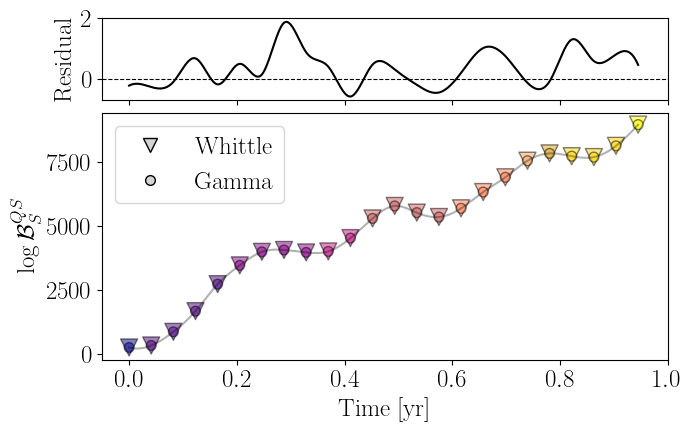

In [8]:
# interpolate with spline for smooth curve
xnew = np.linspace(0, 15 * 86400 * 23 / year, 1000)
spl_cg = interp.UnivariateSpline(time / year, bf_cg, s=0)
spl_cs = interp.UnivariateSpline(time / year, bf_cs, s=0)

# Residual = Gamma - Whittle
residual = spl_cg(xnew) - spl_cs(xnew)

# --- Plot ---

fig = plt.figure(figsize=rect_size, layout="constrained")
# fig.get_layout_engine().set(hspace=0.0, wspace=0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3], figure=fig)

# Top panel: residual
ax_res = fig.add_subplot(gs[0])
ax_res.plot(xnew, residual, color="k")
ax_res.axhline(0, color="k", ls="--", lw=0.8)
ax_res.set_ylabel("Residual")
ax_res.set_xlim(-0.05, 1)
ax_res.tick_params(labelbottom=False)  # hide x-labels here

# Bottom panel: original curves
ax = fig.add_subplot(gs[1], sharex=ax_res)
ax.plot(xnew, spl_cg(xnew), color="k", alpha=0.3)
# ax.plot(xnew, spl_cs(xnew), color='blue', alpha=0.3, ls="--")

ax.scatter(
    time / year,
    bf_cs,
    c=colors_tot,
    label="Whittle",
    marker="v",
    s=150,
    edgecolors="k",
    alpha=0.5,
)
ax.scatter(
    time / year, bf_cg, c=colors_tot, label="Gamma", s=50, edgecolors="k", alpha=0.5
)

ax.set_xlim(-0.05, 1)
ax.set_xlabel("Time [yr]")
ax.set_ylabel(r"$\log\mathcal{B}^{QS}_S$")

legend = [
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="v",
        color="w",
        label="Whittle",
        markerfacecolor="lightgray",
        markersize=10,
        markeredgecolor="k",
    ),
    matplotlib.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Gamma",
        markerfacecolor="lightgray",
        markersize=7,
        markeredgecolor="k",
    ),
]
ax.legend(handles=legend, loc="upper left")
fig.savefig("../plots/Figure6Left.pdf")
